In [31]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [32]:
train_set, test_set = pd.read_csv('sign_mnist_train.csv'), pd.read_csv('sign_mnist_test.csv')

convert to numpy ndarray and reshape

The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

In [33]:
train_labels = train_set['label'].values
train_imgs = np.reshape(train_set.iloc[:, 1:].values, (len(train_set.index), 28, 28)) / 255.0
test_labels = test_set['label'].values
test_imgs = np.reshape(test_set.iloc[:, 1:].values, (len(test_set.index), 28, 28)) / 255.0

Quick look at the images

code from:https://www.tensorflow.org/tutorials/images/cnn#verify_the_data

Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions).

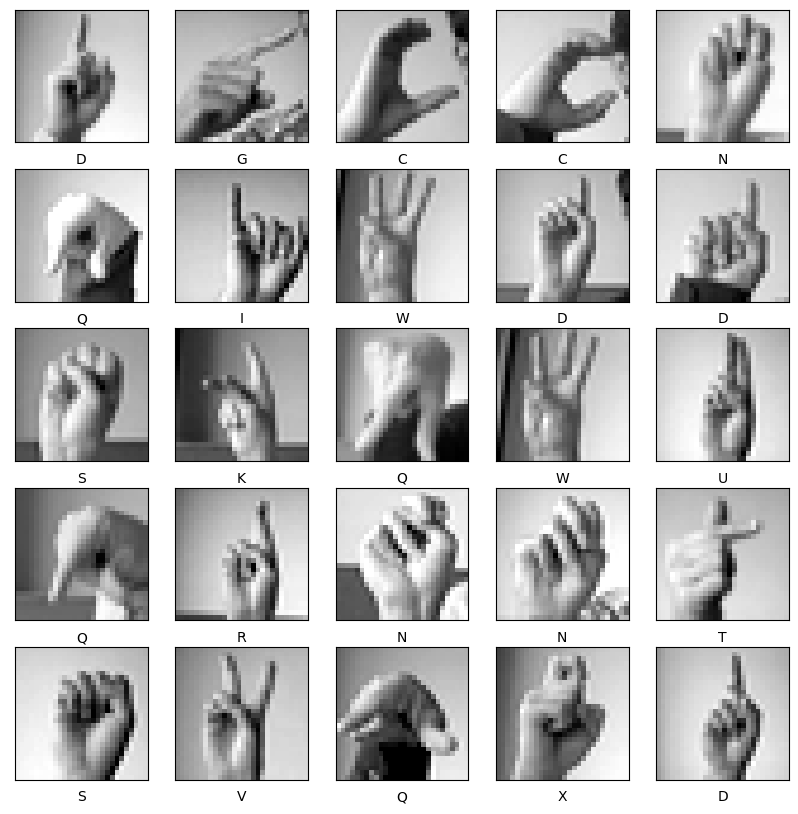

In [34]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_imgs[i], cmap='gray')
    plt.xlabel(chr(ord('A') + train_labels[i]))
plt.show()

since the labels 9=J and 25=Z do not occur, decrease all label values higher than 9 by one so that now 9=K, 10=L, ...

In [35]:
shift = lambda x: np.where(x > 9, x - 1, x)
train_labels = shift(train_labels)
test_labels = shift(test_labels)

In [36]:
print(test_labels[[888, 99]])

[ 9 20]


In [37]:
#load augmented train data
from scipy import ndimage
import random
rng = np.random.default_rng()
modified_imgs = []
modified_labels = []
for img, label in zip(train_imgs, train_labels):
    # ROTATION by (-60, +60) degrees# 
    modified_imgs.append(ndimage.rotate(img, angle=rng.integers(-60, 61), reshape=False, cval=1))
    modified_labels.append(label)
    # BLUR #
    modified_imgs.append(ndimage.gaussian_filter(img, sigma=0.4))
    modified_labels.append(label)
    # BLUR + ROTATION #
    modified_imgs.append(ndimage.gaussian_filter(ndimage.rotate(img, angle=rng.integers(-60, 61), reshape=False, cval=1), sigma=0.25))
    modified_labels.append(label)

# look at the modified images

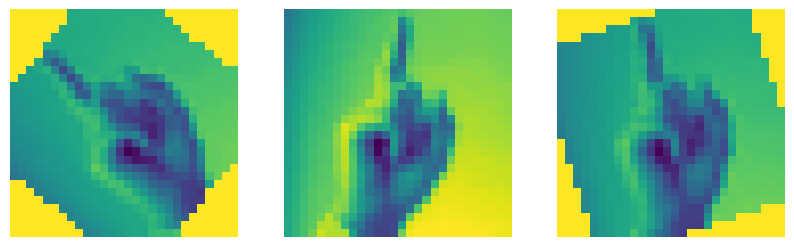

In [38]:
fig = plt.figure(figsize=(10, 3))
ax1, ax2, ax3 = fig.subplots(1, 3)

i = 0
ax1.imshow(modified_imgs[i + 0])
ax1.set_axis_off()
ax2.imshow(modified_imgs[i + 1])
ax2.set_axis_off()
ax3.imshow(modified_imgs[i + 2])
ax3.set_axis_off()
plt.show()

In [39]:
# add augmented data to the training set
train_imgs2 = [img for img in train_imgs]
train_imgs2.extend(modified_imgs)
train_labels2 = [label for label in train_labels]
train_labels2.extend(modified_labels)


In [40]:
#shuffle images after adding the extras
combined = list(zip(train_imgs2, train_labels2))
random.shuffle(combined)
train_imgs2, train_labels2 = zip(*combined)

In [41]:
print(len(train_imgs2))
print(len(train_labels2))
print(np.asarray(train_imgs2[math.ceil(len(train_imgs2)*0.8):-1]).shape)
print(len(train_imgs2) - math.ceil(len(train_imgs2)*0.8))

109820
109820
(21963, 28, 28)
21964


split data into train and validation numpy arrays, 80-20 split

In [42]:
num_train_imgs = math.ceil(len(train_imgs2)*0.8)
num_val_imgs = len(train_imgs2) - num_train_imgs - 1

def make_vector(x):
    v = np.zeros((x.shape[0], 24))
    for xi, vi in zip(x, v):
        vi[xi] = 1.
    return v

train_imgs_np = np.asarray(train_imgs2[0:num_train_imgs]).reshape(num_train_imgs, 28, 28, 1)
val_imgs_np = np.asarray(train_imgs2[num_train_imgs:-1]).reshape(num_val_imgs, 28, 28, 1)
test_imgs_np = np.asarray(test_imgs).reshape(test_imgs.shape[0], 28, 28, 1)

# make_vector makes the labels have shape (24,) with all values 0 except for 1 at the index corresponding to the letter prediction
train_labels_np = make_vector(np.asarray(train_labels2[0:num_train_imgs]))
val_labels_np = make_vector(np.asarray(train_labels2[num_train_imgs:-1]))
test_labels_np = make_vector(test_labels)

In [43]:
print(train_imgs_np[0][0][0].dtype)
print(train_imgs_np.shape)
print(train_labels_np.shape, train_labels_np[0], train_labels2[0])
print(val_imgs_np.shape)
print(test_imgs_np.shape)

float64
(87856, 28, 28, 1)
(87856, 24) [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0
(21963, 28, 28, 1)
(7172, 28, 28, 1)


In [44]:
print(val_imgs_np.shape)
print(train_labels2[num_train_imgs:num_train_imgs+3])
print(val_labels_np[0:3])

(21963, 28, 28, 1)
(18, 13, 6)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Creat the convolutional network

In [45]:
model = tf.keras.models.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28 , 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3)),
    # Dense layers
    layers.Flatten(),
    # layers.Dense(units=512, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(24, activation='softmax')
])

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 576)              

In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_imgs_np, train_labels_np, epochs=2, validation_data=(val_imgs_np, val_labels_np))

Epoch 1/2
2746/2746 [==============================] - 48s 17ms/step - loss: 0.6622 - accuracy: 0.7966 - val_loss: 0.1755 - val_accuracy: 0.9459
Epoch 2/2
2746/2746 [==============================] - 46s 17ms/step - loss: 0.0914 - accuracy: 0.9709 - val_loss: 0.0610 - val_accuracy: 0.9807


# Evaluate the model

225/225 - 1s - loss: 0.4030 - accuracy: 0.9137 - 1s/epoch - 6ms/step
test_loss: 0.40302252769470215
test_acc: 0.9136921167373657


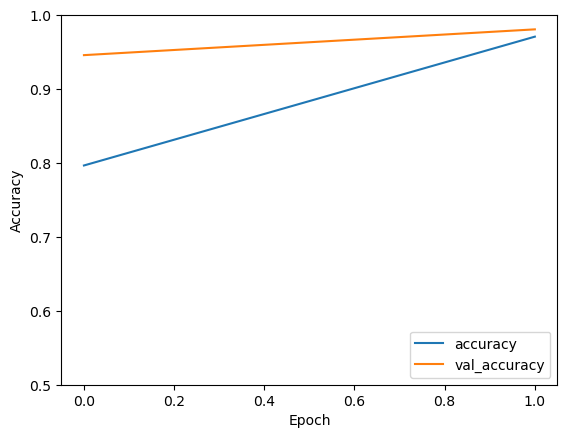

In [48]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_imgs_np,  test_labels_np, verbose=2)
print("test_loss:", test_loss)
print("test_acc:", test_acc)

# model results
test_loss: 0.40302252769470215
test_acc: 0.9136921167373657

# testing the model

In [49]:
label = ord('A') + np.argmax(test_labels_np[0])
prediction = ord('A') + np.argmax(model.predict(np.asarray([test_imgs_np[0]])))
# shift due to 9=J letter not included
label = chr(label) if label < ord('J') else chr(label + 1)
prediction = chr(prediction) if prediction < ord('J') else chr(prediction + 1)
print(f"{label=} {prediction=}")

1/1 [==============================] - 0s 204ms/step
label='G' prediction='G'


In [50]:
print(model.predict(np.asarray([test_imgs_np[0]])))

1/1 [==============================] - 0s 35ms/step
[[5.0186465e-21 4.3217350e-24 3.9674346e-03 1.1493371e-11 2.9821357e-16
  3.5067988e-08 9.9587750e-01 4.6706575e-08 6.4563426e-15 6.9427693e-11
  6.2368145e-11 6.6551604e-17 1.7515212e-18 1.4134146e-04 3.8171484e-13
  2.6031390e-09 3.3995047e-14 2.2916906e-13 1.2866016e-05 4.9198252e-16
  5.0599338e-15 1.3200563e-18 8.1178723e-07 1.5366458e-11]]


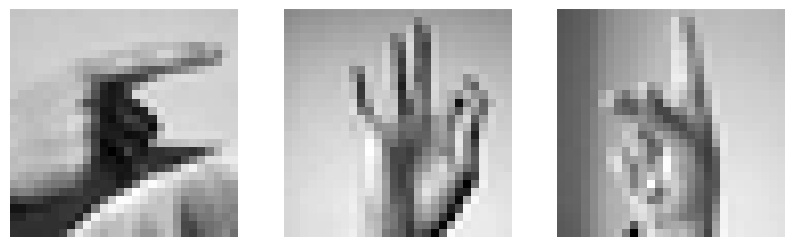

In [51]:
fig = plt.figure(figsize=(10, 3))
ax1, ax2, ax3 = fig.subplots(1, 3)

i = 0
ax1.imshow(test_imgs_np[i], cmap='gray')
ax1.set_axis_off()
ax2.imshow(test_imgs_np[i + 1], cmap='gray')
ax2.set_axis_off()
ax3.imshow(test_imgs_np[i + 2], cmap='gray')
ax3.set_axis_off()
plt.show()

# Save the model

In [52]:
# Save the entire model as a SavedModel.
model.save('../models/asl_model1.2')

INFO:tensorflow:Assets written to: ../models/asl_model1.2\assets


INFO:tensorflow:Assets written to: ../models/asl_model1.2\assets
